In [1]:
import pandas as pd 

import psana as ps
import numpy as np
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial as npply
import sys
import os
import h5py
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter as gf
from sklearn.utils import resample
sys.path.append('/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/TestCode/EarlyScience/AnalyzeH5/')
from chemRIXSAnalysis import *
from ChemRIXSClasses import *
from filterTools import *
sys.path.append('/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/Functions/')
from Functions import *
font = {'size'   : 16}
mpl.rc('font', **font)

cmap = plt.cm.get_cmap('terrain').reversed()

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
exp = 'rixlv1519'
small_data_folder = '/reg/data/ana01/rix/%s/hdf5/smalldata/' % exp #changeme
scan = 11
# raw = h5py.File(small_data_folder+'rixlw1019_Run00%s.h5' % scan)
# print(list(raw.keys()))
# print(list(raw['atmopal'].keys()))



In [3]:
raw = h5py.File(small_data_folder+'rixlv1519_Run00%s.h5' % scan)
print(list(raw.keys()))
laser = np.array(raw['lightStatus']['laser'])
laser.shape
laser[laser==1].shape

['Sums', 'UserDataCfg', 'atmopal', 'ebeam', 'epicsAll', 'gmd', 'hsd', 'lightStatus', 'manta', 'rix_fim2', 'rix_fim2_raw', 'scan', 'timestamp', 'timing', 'xgmd']


(24000,)

In [4]:
raw = h5py.File(small_data_folder+'rixlv1519_Run00%s.h5' % scan)
xgmd = np.array(raw['xgmd']['energy'])
gmd = np.array(raw['gmd']['energy'])
energy_raw = np.array(raw['epicsAll']['MONO_ENERGY_EV'])
# mono_encoder = np.array(raw['mono_encoder']['value'])
pitch_raw = np.array(raw['epicsAll']['MONO_GRATING_PITCH'])
horz_raw = np.array(raw['epicsAll']['MR3K4_pitch'])
evrs = np.array(raw['timing']['eventcodes'])
lxt = np.array(raw['epicsAll']['LAS_VIT_TIME'])
laser = np.array(raw['lightStatus']['laser'])

try:
    tt_pos=raw['tt']['fltpos'][:]
    print('loading TT')
    tt_posps=raw['tt']['fltpos_ps'][:]
    tt_posfwhm=raw['tt']['fltposfwhm'][:]
except:
    print('no TT')
    TT = False

try:
    print('loading fim0')
    fim0_raw = []
    for i in raw['rix_fim0_raw']:
        fim0_raw.append(np.array((raw['rix_fim0_raw'][i])))
    fim0_raw = np.moveaxis(np.asarray(fim0_raw),0,1)
except:
    print('no fim0')
    Fim0 = False

try:
    print('loading fim1')
    fim1_raw = []
    for i in raw['rix_fim1_raw']:
        fim1_raw.append(np.array((raw['rix_fim1_raw'][i])))
    fim1_raw = np.moveaxis(np.asarray(fim1_raw),0,1)
except:
    print('no fim1')
    Fim1 = False

try:
    print('loading andor')
    andor_raw = np.array(raw['andor_dir']['full_area'])
except:
    print('no andor')
    Andor = False

try:
    print('loading fim2')
    fim2_raw = []
    for i in raw['rix_fim2_raw']:
        fim2_raw.append(np.array((raw['rix_fim2_raw'][i])))
    fim2_raw = np.moveaxis(np.asarray(fim2_raw),0,1)
except:
    print('no fim2')
    Fim2 = False
# I0_intensities_fim0, I0_specs_fim0, baselines_fim0 = process_fim(fim0_raw,[0,1,2,3,4,5,6,7]],np.arange(0,50),np.arange(80,220))
# I0_intensities_fim1, I0_specs_fim1, baselines_fim1 = process_fim(fim1_raw,[0,1,2,3,4,5,6,7],np.arange(0,50),np.arange(80,220))
intensities_fim2, specs_fim2, baseline_fim2 = process_fim(fim2_raw,[0,1,2,3,4,5,6,7],np.arange(220,240),np.arange(0,200))
# andor_intensities, andor_specs, baseline_andor = process_andor(andor_raw,np.arange(500,800),np.arange(900,1300))

no TT
loading fim0
no fim0
loading fim1
no fim1
loading andor
no andor
loading fim2


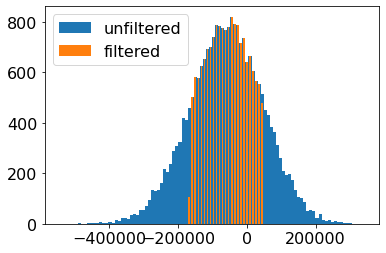

In [5]:
# pumped, unpumped = sort_pump_v_unpump(laser,variable):
B_condition_9 = bounds_filter(intensities_fim2[7,:],[[-500000,'None'],[1]],True)
condition = B_condition_9
laser_filtered = laser.copy()#[condition]

In [8]:
#    bounds_filter(raw_data,filt_param,plot_on):
#    lower_bound = filt_param[0][0]
#    upper_bound = filt_param[0][1]
#    num_stds = filt_param[1][0]


#    lin_filter(data_1,data_2,filt_param,plot_on):
#    width of filter = filt_param[0]
#    force through origin = filt_param[1]  ('True' or 'False')


B_condition_1 = bounds_filter(I0_intensities_fim0[0,:],[[4000,'None'],[3]],True)
B_condition_2 = bounds_filter(I0_intensities_fim0[1,:],[[1000,'None'],[3]],False)
B_condition_3 = bounds_filter(I0_intensities_fim0[2,:],[[1000,'None'],[3]],False)
B_condition_4 = bounds_filter(I0_intensities_fim0[3,:],[[1000,'None'],[3]],False)

B_condition_5 = bounds_filter(I0_intensities_fim1[0,:],[[1000,'None'],[3]],False)
B_condition_6 = bounds_filter(I0_intensities_fim1[1,:],[[1000,'None'],[3]],False)
B_condition_7 = bounds_filter(I0_intensities_fim1[2,:],[[1000,'None'],[3]],False)
B_condition_8 = bounds_filter(I0_intensities_fim1[3,:],[[1000,'None'],[3]],False)

B_condition_9 = bounds_filter(APD_intensities_fim2[0,:],[[-500000,'None'],[2]],False)

bounds_condition = B_condition_1 

L_condition_1 = lin_filter(I0_intensities_fim0[0,:], andor_intensities,[0.05,False],False)
L_condition_2 = lin_filter(I0_intensities_fim0[1,:], andor_intensities,[0.05,False],False)
L_condition_3 = lin_filter(I0_intensities_fim1[0,:], andor_intensities,[0.05,False],False)

L_condition_4 = lin_filter(I0_intensities_fim0[0,:], APD_intensities_fim2[0,:],[0.5,False],False)


linearity_condition = L_condition_3
condition = bounds_condition & linearity_condition
print('')
print(condition.shape)
print(condition[condition==True].shape)
# condition = True
laser_filtered = laser.copy()[condition]

NameError: name 'I0_intensities_fim0' is not defined

In [ ]:
############# MONO SCANS ############

# energy, intensity = mono_spectrum(mono_encoder_ev, n_bins, y_vals):
mono_encoder_ev = np.squeeze(mono_calib(energy_raw,mono_encoder))
n_bins = 100
y_vals = andor_intensities[condition]/I0_intensities_fim0[0,:][condition]
x_vals = mono_encoder_ev[condition]

y_vals = APD_intensities_fim2[0,:][condition]/I0_intensities_fim0[0,:][condition]
x_vals = mono_encoder_ev[condition]

energy_pumped, intensity_pumped = mono_spectrum(x_vals[laser_filtered==1], n_bins, y_vals[laser_filtered==1])
energy_unpumped, intensity_unpumped = mono_spectrum(x_vals[laser_filtered==0], n_bins, y_vals[laser_filtered==0])



plt.figure()
plt.plot(energy_pumped,intensity_pumped,label='pumped')
plt.plot(energy_unpumped,intensity_unpumped,label='unpumped')
plt.legend()
plt.show()

plt.figure()
plt.plot(energy_pumped,(intensity_pumped-intensity_unpumped),label='DeltaT')
plt.legend()


plt.figure()
plt.plot(energy_pumped,(intensity_pumped-intensity_unpumped)/intensity_unpumped,label='DeltaT/T')
plt.legend()

print(str(laser_filtered[laser_filtered==1].shape[0]) + ' pumped shots')
print(str(laser_filtered[laser_filtered==0].shape[0]) + ' pumped shots')


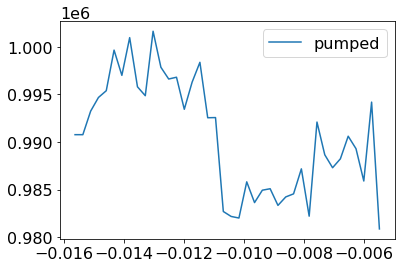

In [58]:
y_vals = np.sum(specs_fim2[7,:],1)#[condition]#/I0_intensities_fim1[0,:][condition]
# y_vals = intensities_fim2[7,:]
x_vals = lxt#[condition]
d_bins_pumped, andor_intensities_time_pumped = time_scan(x_vals[laser_filtered==1], y_vals[laser_filtered==1])
# d_bins_unpumped, andor_intensities_time_unpumped = time_scan(x_vals[laser_filtered==0], y_vals[laser_filtered==0])


plt.figure()
plt.plot(d_bins_pumped, andor_intensities_time_pumped,label='pumped')
# plt.plot(d_bins_unpumped, andor_intensities_time_unpumped,label='unpumped')
plt.legend()

(24000, 256)


(array([4.000e+00, 4.100e+01, 3.390e+02, 1.709e+03, 5.043e+03, 7.750e+03,
        6.159e+03, 2.466e+03, 4.510e+02, 3.800e+01]),
 array([2249.5 , 2677.15, 3104.8 , 3532.45, 3960.1 , 4387.75, 4815.4 ,
        5243.05, 5670.7 , 6098.35, 6526.  ]),
 <BarContainer object of 10 artists>)

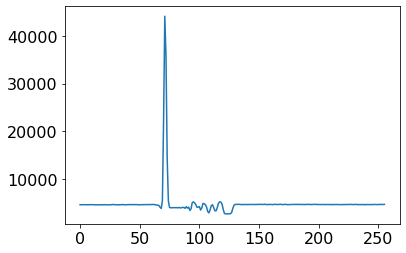

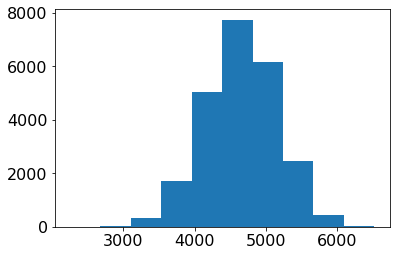

In [60]:
test = np.array(raw['rix_fim2_raw']['raw_7'])
print(test.shape)
plt.plot(np.mean(test,0))

plt.figure()
plt.hist(baseline_fim2[7,:])